# Bayesian Linear Regression Tutorial

## Import code

In [1]:
from LR import *

from scipy.stats import linregress
import matplotlib.pyplot as plt 

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':4,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

## Example with $\phi_i(\mathbf{x}) = x_i$

In this example, Scikit-learn's make_regression() is used to generate synthetic data with 100 features, 1 target variable, and 150 samples. Gaussian noise is added to the output variable with a standard deviation of 10, which corresponds to a precision of $\frac{1}{10^{2}}$ = .01.  

In [2]:
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# number of samples
NS = 500
# number of features
NF = 10
# number of important features 
n_important = 10
# define precision as beta
noise = 20      # std deviation 
beta = (1./noise)**2 # inverse variance 

X, y = sklearn.datasets.make_regression(n_samples=NS, n_features=NF, 
                                        n_informative=n_important, 
                                        n_targets=1, noise=noise)

Decompose data set into training and testing data, setting aside 1/5 of the data for testing. 

In [15]:
N_train = int(.8*NS)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = y[:N_train]
Y_test = y[N_train:]

In [16]:
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_test)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train)).ravel()
Y_test  = Yscaler.transform(np.vstack(Y_test)).ravel()

In [3]:
'''
LR.py by Jaron Thompson

This script includes the BLR class for implementing Bayesian linear regression.
Precision hyper-parameters are updated based on the training data by maximizing
the evidence function using the Expecation-Maximization algorithm.

Also included is a GLR class for general linear regression.

'''
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random, jit
import jax.numpy as jnp
from tqdm import tqdm

### Bayesian Linear Regression model ###

class BLR:

    def __init__(self, X, Y, alpha=1., beta=1., tol=1e-3):
        self.X = X
        self.Y = Y.ravel()

        # number of samples and basis functions
        self.n_samples, self.n_basis = X.shape

        # initialize model parameters
        self.mu = np.zeros(self.n_basis)

        # hyper parameters
        self.alpha = alpha*np.ones(self.n_basis)
        self.A = np.diag(self.alpha)
        self.Ainv = None
        self.beta  = beta

        # parameters of hyper-prior
        self.a = 1e-4
        self.b = 1e-4

        # convergence tolerance
        self.tol = tol

    def fit(self):
        convergence = np.inf
        prev_evidence = 0
        while convergence > self.tol:
            # E step
            self.A = self.alpha*np.eye(self.n_basis) + self.beta*self.X.T@self.X
            self.Ainv = np.linalg.inv(self.A)
            self.Ainv = 1/2*(self.Ainv + self.Ainv.T)
            self.mu = self.beta*self.Ainv@self.X.T@self.Y
            Y_pred = self.X@self.mu
            self.SSE = np.sum((Y_pred - self.Y)**2)

            # M step
            gamma = np.sum(1. - self.alpha*np.diag(self.Ainv))
            # gamma = self.n_basis - self.alpha*np.trace(self.Ainv)
            # self.alpha = np.ones(self.n_basis) / (self.mu**2 + np.diag(self.Ainv) + self.a)
            self.alpha = (self.n_basis) / (np.dot(self.mu, self.mu) + np.trace(self.Ainv) + self.a)
            self.beta  = (self.n_samples) / (self.SSE + gamma/self.beta + self.b)

            # evaluate convergence
            current_evidence = self.evidence()
            print("Evidence: {:.3f}".format(current_evidence))
            convergence = np.abs(prev_evidence - current_evidence) / np.max([1,np.abs(prev_evidence)])
            prev_evidence = current_evidence

    def evidence(self):
        ev = np.sum(np.log(np.linalg.eigvalsh(self.Ainv))) + \
             np.sum(np.log(self.alpha)) + \
             self.n_samples*np.log(self.beta) - self.beta*self.SSE - \
             np.dot(self.alpha*self.mu, self.mu)
        return ev/2.

    def fit_MCMC_numpyro(self, num_warmup=500, num_samples=1000, rng_key=0):
        # define probabilistic model
        predict = jit(lambda X,mu: X@mu)

        def model(X, y):
            if self.Ainv is None:
                # sample parameters
                with numpyro.plate("weights", self.n_basis):
                    alpha = numpyro.sample("alpha", dist.Exponential(rate=self.a))
                    mu = numpyro.sample("mu", dist.Normal(loc=0., scale=(1./alpha)**.5))
                    
                # sample likelihood
                beta = numpyro.sample("beta", dist.Exponential(rate=self.b))
                L = numpyro.sample('y', dist.Normal(loc=predict(X,mu), scale=(1./beta)**.5), obs=y)
            else:
                # sample parameters
                mu = numpyro.sample('mu', dist.MultivariateNormal(loc=self.mu, covariance_matrix=self.Ainv))
                # sample likelihood
                L = numpyro.sample('y', dist.Normal(loc=predict(X,mu), scale=(1./self.beta)**.5), obs=y)

        # instantiate MCMC object with NUTS kernel
        self.mcmc = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples)
        self.mcmc.warmup(random.PRNGKey(rng_key), self.X, self.Y, init_params=0.)
        self.mcmc.run(random.PRNGKey(rng_key), self.X, self.Y, init_params=0.)
        # save posterior samples
        self.posterior_params = np.array(self.mcmc.get_samples()['mu'])
        if 'beta' in blr.mcmc.get_samples().keys():
            self.beta = np.mean(blr.mcmc.get_samples()['beta'])
            
    ### MCMC Code ###

    def fit_MCMC(self, num_warmup=1000, num_samples=1000, num_chains=4, seed=0):
        
        # total number of samples = number of chains * num_samples
        num_samples *= num_chains
        
        # generate random key
        key = random.PRNGKey(seed)
        
        # compile function to make predictions
        predict = jit(lambda theta: self.X@theta)
        
        # cholesky decomposition of Laplace estimated parameter covariance
        L = np.linalg.cholesky(self.Ainv)
        
        # use Laplace approximated posterior as proposal distribution
        @jit
        def sample_proposal(subkey, current_theta):
            
            # sample from Gaussian 
            z_theta = random.normal(subkey, shape=(self.n_basis,))
            theta = current_theta + L@z_theta
            
            # return samples
            return theta
            
        # compile function to compute acceptance probability
        @jit
        def acceptance_prob(new_pred, old_pred, new_theta, old_theta):
            # compute residuals
            new_res = self.Y - new_pred
            old_res = self.Y - old_pred
            
            # log of acceptance probability
            log_ratio = (-self.beta/2.*jnp.sum(new_res**2) - self.alpha/2.*jnp.sum(new_theta**2) 
                         +self.beta/2.*jnp.sum(old_res**2) + self.alpha/2.*jnp.sum(old_theta**2))
            
            # take exponent and return
            return jnp.exp(log_ratio)
            
        # run warmup (don't store samples)
        pbar = tqdm(desc='Warmup: ', total=num_warmup)
        theta = np.copy(self.mu)  # np.zeros(self.n_basis) #
        old_pred = predict(theta)
        n_acc = 0
        while n_acc < num_warmup:
            # generate new random key
            key, subkey = random.split(key)
            
            # sample from proposal
            new_theta = sample_proposal(subkey, theta)
            
            # make predictions
            new_pred = predict(new_theta)
    
            # compute acceptance probability
            acc_prb = acceptance_prob(new_pred, old_pred, new_theta, theta)
            
            # decide whether to accept new parameters
            if np.min([1., acc_prb]) > random.uniform(subkey):
                theta = new_theta
                old_pred = new_pred
                n_acc += 1 
                pbar.update()
        pbar.close()   
                
        # run MCMC and store samples
        pbar = tqdm(desc='Run: ', total=num_samples)
        acc_theta = [theta]
        n_acc = 0
        n_try = 0
        while n_acc < num_samples:
            # generate new random key
            key, subkey = random.split(key)
            
            # sample from proposal
            new_theta = sample_proposal(subkey, acc_theta[-1])
            
            # make predictions
            new_pred = predict(new_theta)
    
            # compute acceptance probability
            acc_prb = acceptance_prob(new_pred, old_pred, new_theta, acc_theta[-1])
            
            # decide whether to accept new parameters
            if np.min([1., acc_prb]) > random.uniform(subkey):
                acc_theta.append(new_theta)
                old_pred = new_pred
                n_acc += 1
                pbar.update()
                
            # count number of trials
            n_try += 1
        pbar.close()
                
        # store posterior samples
        self.posterior_params = np.stack(acc_theta)[1:]
                
        # acceptance probability
        print("acceptance ratio: ", n_acc / n_try)
        
        # compute potential scale reduction
        chains = np.stack(np.split(self.posterior_params, num_chains))
        m,n,p = chains.shape
        B = n/(m-1) * np.sum((np.mean(chains, 1) - np.mean(chains, (0,1)))**2, 0)
        W = np.mean( 1/(n-1)*np.sum((np.transpose(chains, (1,0,2)) - np.mean(chains, 1))**2 , 0) , 0)
        var_plus = (n-1)/n*W + B/n
        R = np.round(np.sqrt(var_plus/W),2)
        
        # variogram of t
        Vt = lambda t: 1/(m*(n-t))*np.sum(np.sum(np.stack([(chains[:, i] - chains[:, i-t])**2 for i in range(t+1,n)]), 0), 0)
        # lag of t 
        pt = lambda t: 1 - Vt(t) / (2*var_plus)

        # compute effective number of samples for each feature
        n_eff = []
        for i in range(blr.n_basis):
            t = 1
            pt_sum = 0
            while pt(t+1)[i]+pt(t+2)[i] > 0 and t < n-3:
                pt_sum += pt(t)[i]
                t += 1 
            n_eff.append(m*n / (1 + 2*pt_sum))
        
        # save statistics 
        self.mcmc_summary = pd.DataFrame()
        self.mcmc_summary['Params'] = ['w'+str(i+1) for i in range(self.n_basis)]
        self.mcmc_summary['mean'] = np.mean(self.posterior_params, 0)
        self.mcmc_summary['median'] = np.median(self.posterior_params, 0)
        self.mcmc_summary['stdv'] = np.std(self.posterior_params, 0)
        self.mcmc_summary['n_eff'] = n_eff
        self.mcmc_summary['r_hat'] = R 

    def predict(self, X):
        y_pred = X@self.mu
        y_var  = 1/self.beta + np.einsum('ni,ij,nj->n', X, self.Ainv, X)
        return y_pred, np.sqrt(y_var)

    def predict_MCMC(self, X):
        y_preds  = np.einsum('ni,si->sn', X, self.posterior_params)
        y_preds += np.random.randn(y_preds.shape[0], y_preds.shape[1])*(1/self.beta)**.5
        return np.mean(y_preds, 0), np.std(y_preds, 0)


Fit a Bayesian linear regression model and maximize evidence function

In [17]:
blr = BLR(X_train, Y_train)
blr.fit()
#blr.fit_MCMC()

Evidence: 509.050
Evidence: 549.255
Evidence: 545.520
Evidence: 545.369


# Make predictions on train data

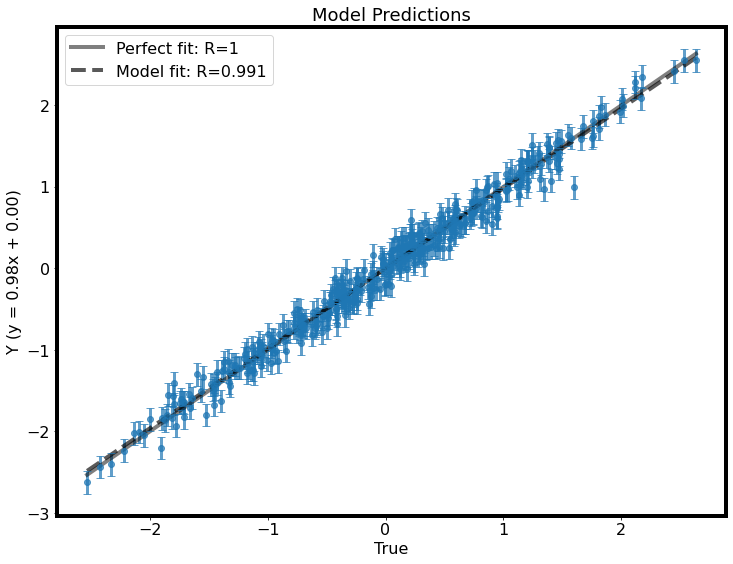

In [18]:
Y, Y_stdv = blr.predict(X_train)

OneToOne = np.linspace(np.min(Y_train), np.max(Y_train), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_train, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_train, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

In [25]:
import math 
from scipy.stats import norm

t_dist = lambda x, b: b * np.sqrt(1 / (2*np.pi)) * (b + x**2 / 2) ** (-1.5) * math.gamma(1.5) 
norm_dist = norm(loc=0, scale=np.sqrt(1/blr.beta))

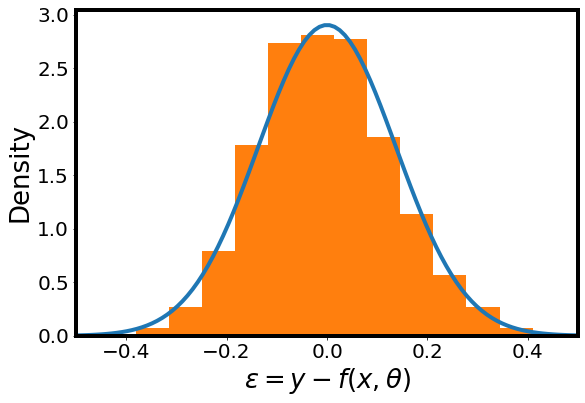

In [30]:
plt.figure(figsize=(9, 6))
x = np.linspace(-.5, .5, 100)
#plt.plot(x, t_dist(x, 1e-3), linewidth=4)
plt.plot(x, norm_dist.pdf(x), linewidth=4)
plt.hist(Y_train - Y, bins=15, density=True)
plt.xlim([-.5, .5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Density", fontsize=26)
plt.xlabel(r"$\varepsilon = y - f(x, \theta)$", fontsize=26)
plt.savefig("Noise_model_validation.pdf")
plt.show()

# Make predictions on test data 

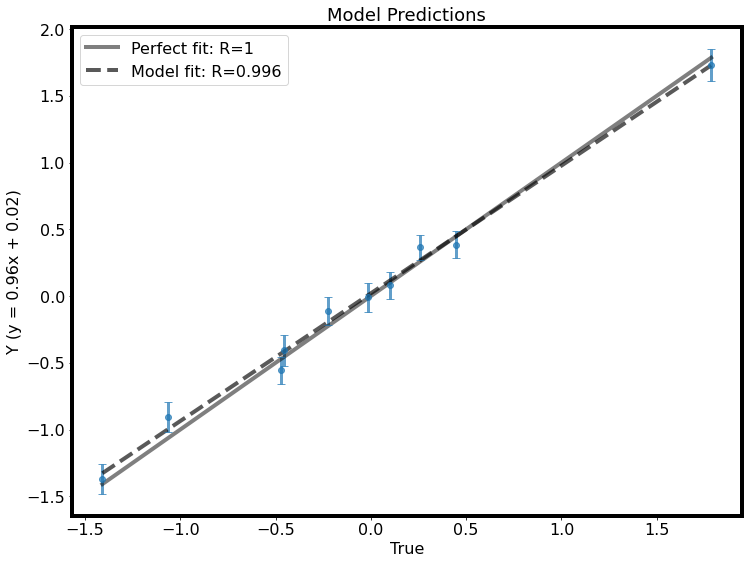

In [11]:
Y, Y_stdv = blr.predict_MCMC(X_test)

OneToOne = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_test, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_test, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

In [12]:
# import numpy as np
# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer import MCMC, NUTS
# from jax import random, jit

# def model(X, y):
#     mu = numpyro.sample('mu', 
#                         dist.MultivariateNormal(loc=blr.mu, precision_matrix=blr.A))
#     L = numpyro.sample('y', dist.Normal(loc=X@mu, scale=1/blr.beta), obs=y)

# mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=1000)

# rng_key = random.PRNGKey(0)
# mcmc.run(rng_key, X_train, Y_train.ravel())

# blr.mu = np.array(np.mean(mcmc.get_samples()['mu'], 0))

# Compare to MCMC 

In [13]:
blr.fit_MCMC()

Run: 100%|█████████████████████████████████| 4000/4000 [00:07<00:00, 507.50it/s]


acceptance ratio:  0.14788524105294293


In [14]:
blr.mu[2]

0.23583242057451298

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

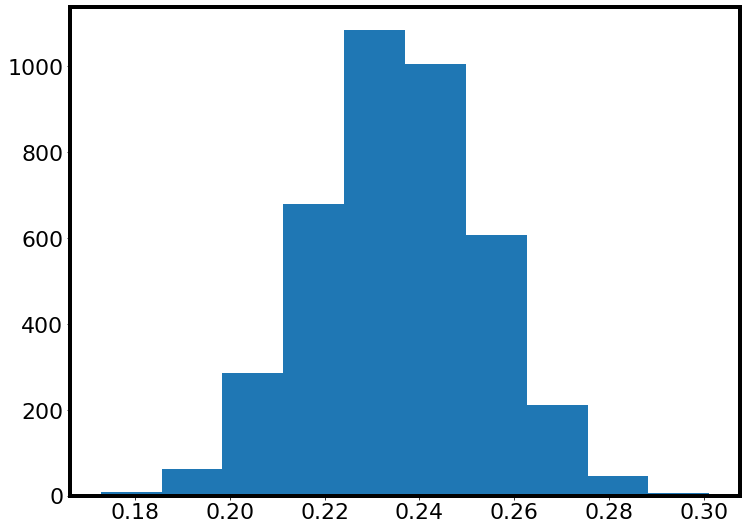

In [15]:
plt.hist(blr.posterior_params[:, 2])
plt.plot

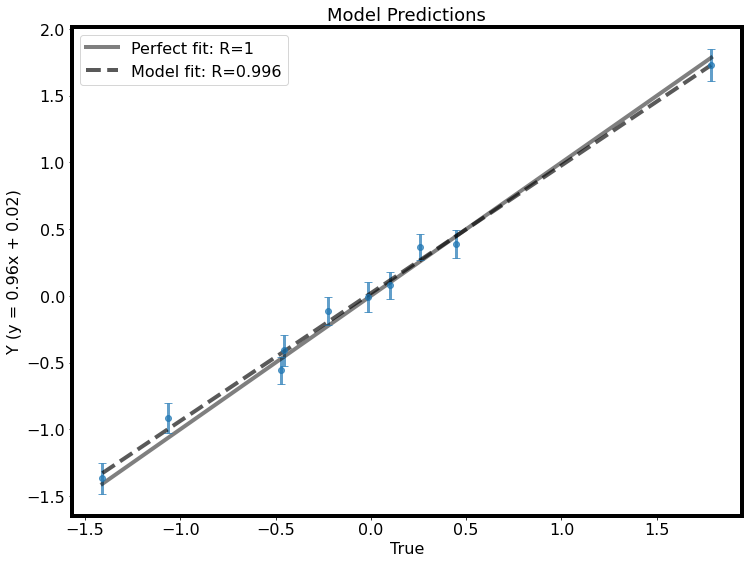

In [16]:
Y, Y_stdv = blr.predict_MCMC(X_test)

OneToOne = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_test, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_test, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

In [18]:
blr.mcmc_summary

,Params,mean,median,stdv,n_eff,r_hat
0,w1,0.046847,0.046547,0.019193,855.263514,1.0
1,w2,0.255886,0.255857,0.016743,642.820333,1.0
2,w3,0.235665,0.235445,0.017911,852.148176,1.0
3,w4,0.322452,0.322335,0.019404,827.009791,1.0
4,w5,0.325043,0.325016,0.017799,706.245826,1.0
5,w6,0.185331,0.185308,0.017194,798.756323,1.0
6,w7,0.135554,0.135367,0.017824,777.357103,1.0
7,w8,0.258157,0.257728,0.016135,853.785743,1.0
8,w9,0.405093,0.404884,0.017300,880.836074,1.0
9,w10,0.283633,0.284055,0.017043,850.722940,1.0


## Example with $\phi_i(\mathbf{x}) = [1, x_i, x_i^2, ..., x_i^5]^T$

Generate data with response that is non-linear in x

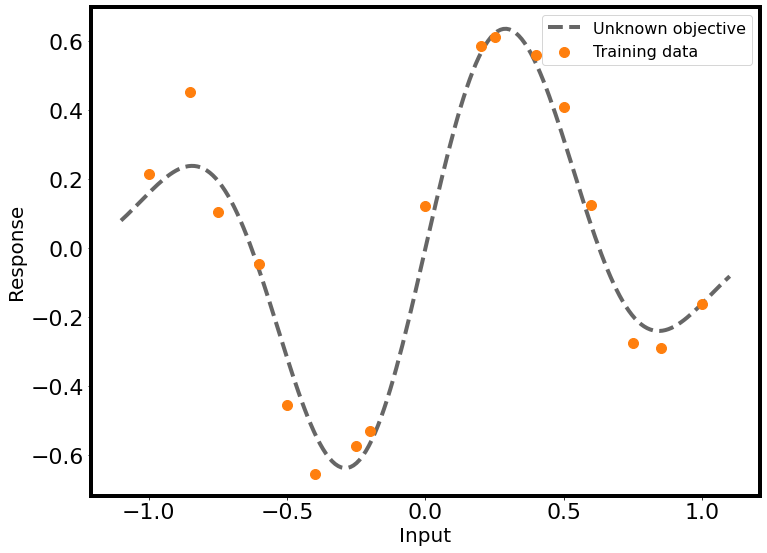

In [32]:
def f(x, noise):
    return .7*np.sin(5 * x) * (1 - np.tanh(x ** 2)) + np.random.randn() * noise/100

def generate_data(Xlist, noise=0.):
    Nsamples = len(Xlist)
    X = np.zeros([Nsamples, 1])
    Y = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        X[i, :] = Xlist[i]
        # add some standard Gaussian noise to Y
        Y[i] = f(Xlist[i], noise)

    return np.vstack(X), np.vstack(Y)

# train data points
Xlist = [-1, -.85, -.75, -.6, -.5, -.4, -.25, -.2, 0, .2, .25, .4, .5, .6, .75, .85, 1]
X_train, Y_train = generate_data(Xlist, noise=10.0)
X_test, Y_test = generate_data(list(np.linspace(-1.1, 1.1, 200)))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Define basis function

In [33]:
def x_basis(X):
    b = np.vstack(np.ones(X.shape[0]))
    return np.concatenate((b, X, X**2, X**3, X**4, X**5, X**6), -1)

Fit a Bayesian linear regression model and maximize evidence function

In [34]:
blr = BLR(x_basis(X_train), Y_train, alpha=1e-5)
blr.fit()

Evidence: 7.000
Evidence: 10.622
Evidence: 11.874
Evidence: 12.368
Evidence: 13.857
Evidence: 15.397
Evidence: 15.911
Evidence: 15.822
Evidence: 15.656
Evidence: 15.552
Evidence: 15.501
Evidence: 15.478
Evidence: 15.468


Make predictions on test data

In [35]:
Y, Y_stdv = blr.predict(x_basis(X_test))

Plot results

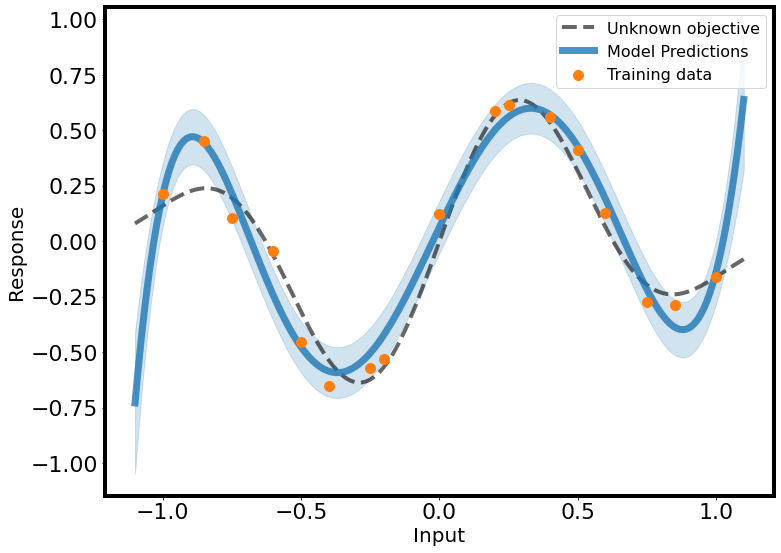

In [38]:
inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = 1. 
plt.fill_between(X_test.ravel(), Y - unc_factor*Y_stdv, Y + unc_factor*Y_stdv, 
                 color='C0', alpha=0.2, zorder=1)

#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
#plt.ylim([-1.9, 1.5])
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig("Figures/blr_example.pdf", transparent=True, dpi=100)
plt.show()

In [24]:
(1./blr.beta)**.5

0.20334694986000632

# Compare to MCMC 

In [25]:
blr.fit_MCMC()

Run: 100%|█████████████████████████████████| 4000/4000 [00:06<00:00, 575.08it/s]


acceptance ratio:  0.22955523672883787


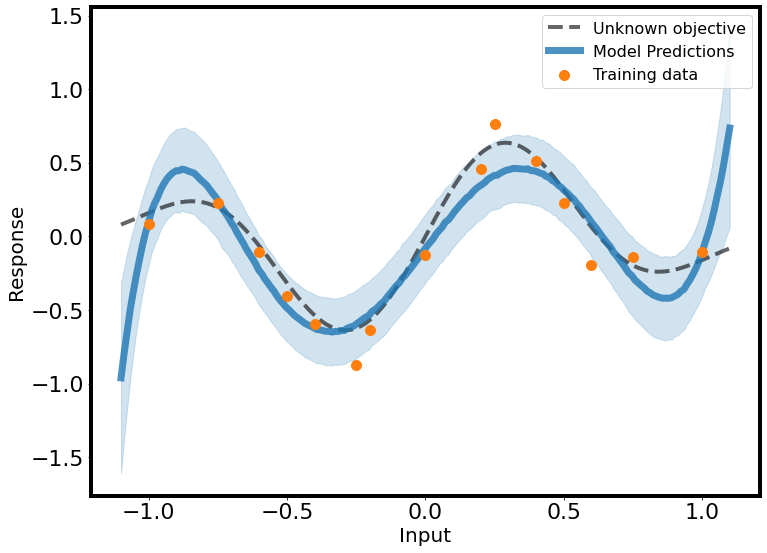

In [26]:
Y, Y_stdv = blr.predict_MCMC(x_basis(X_test))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = 1. 
plt.fill_between(X_test.ravel(), Y - unc_factor*Y_stdv, Y + unc_factor*Y_stdv, 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
#plt.ylim([-1.9, 1.5])
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
#plt.savefig("Figures/example_2.png", dpi=100)
plt.show()

In [27]:
blr.mcmc_summary

,Params,mean,median,stdv,n_eff,r_hat
0,w1,-0.082989,-0.078874,0.111962,823.064788,1.0
1,w2,2.505748,2.515048,0.358071,820.946114,1.0
2,w3,-0.171636,-0.169401,1.049731,777.374176,1.0
3,w4,-8.222887,-8.266437,1.411511,781.690607,1.0
4,w5,0.859551,0.838930,2.770470,623.701903,1.0
5,w6,5.611954,5.642994,1.132542,744.444554,1.0
6,w7,-0.608847,-0.565611,1.917986,592.968346,1.0
